In [6]:
%pip install requests tensorflow[and-cuda] aria2 netCDF4 numpy xarray scikit-learn tqdm pickleshare

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 20.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 22.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 23.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 23.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import logging

# Setup logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s - %(levelname)s - %(message)s")

# Constants
DOWNLOAD_DATA = True
DATA_DIR = './data'  # Directory containing .tar.gz files
EXTRACT_DIR = os.path.join(DATA_DIR, 'extracted')
TRAIN_DIR = "./data/extracted/train"
TEST_DIR = "./data/extracted/test"
TRAIN_OUTPUT_DIR = "./data/tfrecords/train"
TEST_OUTPUT_DIR = "./data/tfrecords/test"

In [ ]:
import subprocess
import tarfile

# Bucket and endpoint configuration
CUSTOM_ENDPOINT = "bbproxy.meyerstk.com/file"
APP = "TorNetBecauseZenodoSlow"
TMP_FILE = os.path.join(DATA_DIR, "tmp.txt")

# Ensure directories exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(EXTRACT_DIR, exist_ok=True)

def download_links(links):
    """
    Download files from the provided links using aria2c.
    Uses a file named tmp.txt in DATA_DIR for links.
    """
    try:
        # Write links to tmp.txt
        with open(TMP_FILE, 'w') as file:
            file.writelines(link + '\n' for link in links)
        logging.info(f"Temporary file created: {TMP_FILE}")

        # Run aria2c to download files
        logging.info(f"Starting downloads for links: {', '.join(links)}")
        command = [
            "aria2c",
            "-j", "5",                # Download up to 3 files concurrently
            "-x", "16",               # Use up to 16 connections per file
            # "--console-log-level=info",
            "-s", "16",               # Split each file into 16 segments
            "--dir", DATA_DIR,        # Specify the download directory
            "-i", TMP_FILE            # Input file with download links
        ]
        subprocess.run(command, check=True)
        logging.info("Downloads completed successfully.")
    except Exception as e:
        logging.error(f"Error during download: {e}")
        exit(1)
    finally:
        if os.path.exists(TMP_FILE):
            os.remove(TMP_FILE)
            logging.info(f"Temporary file deleted: {TMP_FILE}")


def download_files_with_aria():
    """
    Download files from a public Backblaze B2 bucket served via a custom endpoint using aria2c.
    """
    logging.info("Starting download process with aria2c...")

    # # List of files to download
    file_list = [
        "tornet_2013.tar.gz",
        "tornet_2014.tar.gz",
        "tornet_2015.tar.gz",
        "tornet_2016.tar.gz",
        "tornet_2017.tar.gz",
        "tornet_2018.tar.gz",
        "tornet_2019.tar.gz",
        "tornet_2020.tar.gz",
        "tornet_2021.tar.gz",
        "tornet_2022.tar.gz",
    ]

    # Construct the public URLs
    links = [f"https://{CUSTOM_ENDPOINT}/{APP}/{file_name}" for file_name in file_list]
    
    # Filter out already downloaded files
    links_to_download = [
        link for link in links
        if not os.path.exists(os.path.join(DATA_DIR, os.path.basename(link)))
    ]

    if links_to_download:
        download_links(links_to_download)
    else:
        logging.info("All files already downloaded.")


def extract_local_tar_files():
    """
    Extract all .tar.gz files from the local DATA_DIR to EXTRACT_DIR.
    """
    logging.info("Starting extraction process...")
    for file_name in os.listdir(DATA_DIR):
        if file_name.endswith('.tar.gz'):
            file_path = os.path.join(DATA_DIR, file_name)
            logging.info(f'Extracting {file_path}...')
            with tarfile.open(file_path, 'r:gz') as tar:
                tar.extractall(path=EXTRACT_DIR)
            logging.info(f'Extracted {file_path} to {EXTRACT_DIR}')

            os.remove(file_path)

if DOWNLOAD_DATA:
    download_files_with_aria()
    extract_local_tar_files()

In [11]:
import numpy as np
import xarray as xr
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from collections import defaultdict, Counter

# Constants for normalization
CHANNEL_MIN_MAX = {
    'DBZ': [-20., 60.],
    'VEL': [-60., 60.],
    'KDP': [-2., 5.],
    'RHOHV': [0.2, 1.04],
    'ZDR': [-1., 8.],
    'WIDTH': [0., 9.]
}

VARIABLES = ['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']

def parse_nc_file(file_path):
    """
    Parse and preprocess a single .nc file.
    Output: features (4D array), label (int)
    """
    try:
        with xr.open_dataset(file_path, engine="netcdf4") as ds:
            data_list = []

            # Process radar variables
            for var in VARIABLES:
                if var not in ds:
                    raise ValueError(f"Variable {var} not found in dataset.")

                var_data = ds[var].values  # Shape: [time, azimuth, range, sweep]
                var_min, var_max = CHANNEL_MIN_MAX[var]

                # Handle missing data and normalize
                var_data = np.nan_to_num(var_data, nan=0, posinf=0, neginf=0)
                var_data[var_data == ds.attrs.get('MissingDataFlag', -999.0)] = 0
                var_data = np.clip(var_data, var_min, var_max)
                var_data = (var_data - var_min) / (var_max - var_min)
                var_data = (var_data * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

                data_list.append(var_data)

            # Combine variables into the channel dimension
            data = np.stack(data_list, axis=-1)  # Shape: [time, azimuth, range, sweep, variables]
            data = data.transpose(0, 1, 2, 4, 3)  # [time, azimuth, range, variables, sweep]
            data = data.reshape(data.shape[0], data.shape[1], data.shape[2], -1)  # [time, azimuth, range, channels]

            # Ensure correct time dimension
            if data.shape[0] < 4:
                raise ValueError(f"File {file_path} has fewer than 4 time steps.")

            # Extract label from category attribute
            label = ds.attrs.get("category", "NUL")
            label = 1 if label == "TOR" else 0

            return data[:4], label  # Return first 4 time steps

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None, None

def serialize_example(features, label):
    """
    Serialize features and labels into a TFRecord-compatible format.
    """
    feature = {
        "features": tf.train.Feature(bytes_list=tf.train.BytesList(value=[features.tobytes()])),
        "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

def group_files_by_year(input_dir):
    """
    Group `.nc` files by year.
    """
    files_by_year = defaultdict(list)
    
    for file in Path(input_dir).rglob("*.nc"):
        year = file.parent.name  # Assuming year is the folder name
        files_by_year[year].append(file)

    return files_by_year

def process_year(year, files, output_dir):
    """
    Process files for a given year and save them as a TFRecord file.
    """
    output_path = str(Path(output_dir) / f"{year}.tfrecord")
    local_label_counts = Counter()  # Local Counter for this process
    
    with tf.io.TFRecordWriter(output_path) as writer:
        for file in tqdm(files, desc=f"Processing year {year}"):
            features, label = parse_nc_file(file)
            if features is not None:
                example = serialize_example(features, label)
                writer.write(example)
                local_label_counts[label] += 1  # Update local counts

    print(f"Completed {year}: {len(files)} files")
    return local_label_counts 
    
def create_tfrecords(input_dir, output_dir, num_workers=4):
    """
    Create TFRecords for all years in train/test directories in parallel.
    Aggregate label counts from all processes.
    """
    os.makedirs(output_dir, exist_ok=True)
    files_by_year = group_files_by_year(input_dir)

    total_label_counts = Counter()  # Global Counter for all processes

    # Process each year in parallel
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = [
            executor.submit(process_year, year, files, output_dir)
            for year, files in files_by_year.items()
        ]
        for future in tqdm(futures, desc="Processing all years"):
            year_label_counts = future.result()  # Get label counts from process
            total_label_counts.update(year_label_counts)  # Aggregate counts
    
    return total_label_counts

# Create TFRecords
print("Creating training TFRecords...")
train_counts = create_tfrecords(TRAIN_DIR, TRAIN_OUTPUT_DIR, num_workers=50)

print("Creating testing TFRecords...")
test_counts = create_tfrecords(TEST_DIR, TEST_OUTPUT_DIR, num_workers=50)

total_label_counts = train_counts + test_counts
print(f"Total Label Counts: {total_label_counts}")

Creating training TFRecords...


Processing year 2013: 100%|██████████| 3498/3498 [02:36<00:00, 22.38it/s]]


Completed 2013: 3498 files


Processing year 2018: 100%|██████████| 15360/15360 [11:21<00:00, 22.54it/s]


Completed 2018: 15360 files


Processing year 2017: 100%|██████████| 16927/16927 [12:31<00:00, 22.51it/s]


Completed 2017: 16927 files


Processing year 2014: 100%|██████████| 17447/17447 [12:56<00:00, 22.46it/s]


Completed 2014: 17447 files


Processing year 2020: 100%|██████████| 18147/18147 [13:28<00:00, 22.45it/s]


Completed 2020: 18147 files


Processing year 2016: 100%|██████████| 18791/18791 [13:57<00:00, 22.44it/s]


Completed 2016: 18791 files


Processing year 2021: 100%|██████████| 19049/19049 [14:15<00:00, 22.26it/s]


Completed 2021: 19049 files


Processing year 2015: 100%|██████████| 19721/19721 [14:39<00:00, 22.43it/s]


Completed 2015: 19721 files


Processing year 2019: 100%|██████████| 20588/20588 [15:19<00:00, 22.39it/s]


Completed 2019: 20588 files


Processing year 2022: 100%|██████████| 22138/22138 [16:34<00:00, 22.27it/s]


Completed 2022: 22138 files


Processing all years: 100%|██████████| 10/10 [16:34<00:00, 99.50s/it]


Creating testing TFRecords...


Processing year 2013: 100%|██████████| 573/573 [00:25<00:00, 22.34it/s]]


Completed 2013: 573 files


Processing year 2018: 100%|██████████| 2518/2518 [01:51<00:00, 22.49it/s]


Completed 2018: 2518 files


Processing year 2014: 100%|██████████| 2546/2546 [01:54<00:00, 22.31it/s]


Completed 2014: 2546 files


Processing year 2022: 100%|██████████| 2777/2777 [02:04<00:00, 22.25it/s]


Completed 2022: 2777 files


Processing year 2016: 100%|██████████| 2951/2951 [02:11<00:00, 22.44it/s]


Completed 2016: 2951 files


Processing year 2017: 100%|██████████| 3145/3145 [02:20<00:00, 22.35it/s]


Completed 2017: 3145 files

Processing year 2021:  73%|███████▎  | 3119/4268 [02:20<00:52, 21.92it/s]

Processing year 2015: 100%|██████████| 3902/3902 [02:53<00:00, 22.44it/s]


Completed 2015: 3902 files


Processing year 2019: 100%|██████████| 4031/4031 [03:00<00:00, 22.33it/s]


Completed 2019: 4031 files


Processing year 2021: 100%|██████████| 4268/4268 [03:12<00:00, 22.17it/s]


Completed 2021: 4268 files


Processing year 2020: 100%|██████████| 4756/4756 [03:31<00:00, 22.46it/s]


Completed 2020: 4756 files


Processing all years: 100%|██████████| 10/10 [03:31<00:00, 21.20s/it]


Total Label Counts: Counter({0: 189276, 1: 13857})


In [16]:
%store total_label_counts

Stored 'total_label_counts' (Counter)


/usr/local/lib/python3.11/dist-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/total_label_counts requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


In [2]:
from collections import Counter
total_label_counts = counter = Counter({0: 189276, 1: 13857})

In [3]:
import tensorflow as tf 

# Create a MirroredStrategy for multiple GPUs
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

2024-12-05 22:06:42.097517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733436402.119746     486 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733436402.126465     486 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 22:06:42.149572: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


I0000 00:00:1733436404.873290     486 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1733436404.874090     486 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22282 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:81:00.0, compute capability: 8.9
I0000 00:00:1733436404.874757     486 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22282 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c1:00.0, compute capability: 8.9
I0000 00:00:1733436404.875455     486 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22282 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c2:00.0, compute capability: 8.9


Number of devices: 4


In [10]:
from pathlib import Path
import numpy as np 

def parse_tfrecord(example):
    feature_description = {
        "features": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)

    # Decode features and reshape directly to the known fixed shape
    features = tf.io.decode_raw(parsed_example["features"], tf.uint8)
    features = tf.reshape(features, [4, 120, 240, 12])  # Directly use the fixed shape
    features = tf.cast(features, tf.float16) / 255.0  # Scale back to [0, 1]

    # Parse label
    label = tf.cast(parsed_example["label"], tf.float32)
    label = tf.reshape(label, (1,))  # Ensure label has shape [1]

    return features, label

def create_tf_dataset_with_count(tfrecord_dir, batch_size, shuffle=True):
    """
    Create a tf.data.Dataset from TFRecord files and count total samples.
    """
    tfrecord_files = list(Path(tfrecord_dir).glob("*.tfrecord"))
    dataset = tf.data.TFRecordDataset(tfrecord_files)

    sample_count = 0
    for record in dataset:
        sample_count += 1

    dataset = dataset.map(parse_tfrecord)
    if shuffle:
        dataset = dataset.shuffle(1000)
    
    batch_size *= strategy.num_replicas_in_sync
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    dataset = dataset.repeat()
    
    return dataset, sample_count

BATCH_SIZE = 1

train_dataset, train_sample_count = create_tf_dataset_with_count(TRAIN_OUTPUT_DIR, batch_size=BATCH_SIZE)
test_dataset, test_sample_count = create_tf_dataset_with_count(TEST_OUTPUT_DIR, batch_size=BATCH_SIZE, shuffle=False)

train_steps_per_epoch = np.ceil(train_sample_count / BATCH_SIZE).astype(int)
validation_steps = np.ceil(test_sample_count / BATCH_SIZE).astype(int)

print(f"Train samples: {train_sample_count} (Steps: {train_steps_per_epoch}), Test samples: {test_sample_count} (Steps: {validation_steps})")

for features, labels in train_dataset.take(1):
    print(f"Feature shape: {features.shape}, Label shape: {labels.shape}")

2024-12-05 22:18:08.931159: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train samples: 171666 (Steps: 10730), Test samples: 31467 (Steps: 1967)
Feature shape: (64, 4, 120, 240, 12), Label shape: (64, 1)


In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models, layers

def create_3d_torcnn(input_shape=(4, 120, 240, 12), dropout_rate=0.1):
    """
    Define a 3D CNN model for tornado detection with advanced optimizations.
    """
    model = models.Sequential(
        [
            # Input Layer
            layers.Input(shape=input_shape),
            
            # Block 1
            layers.Conv3D(32, (3, 3, 3), padding="same", kernel_regularizer=l2(0.001)),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Conv3D(32, (3, 3, 3), padding="same", kernel_regularizer=l2(0.001)),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.1),
            layers.MaxPooling3D((1, 2, 2)),
            layers.SpatialDropout3D(dropout_rate),

            # Block 2
            layers.Conv3D(64, (3, 3, 3), padding="same", kernel_regularizer=l2(0.001)),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Conv3D(64, (3, 3, 3), padding="same", kernel_regularizer=l2(0.001)),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.1),
            layers.MaxPooling3D((1, 2, 2)),
            layers.SpatialDropout3D(dropout_rate),

            # Block 3
            layers.Conv3D(128, (3, 3, 3), padding="same", kernel_regularizer=l2(0.001)),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Conv3D(128, (3, 3, 3), padding="same", kernel_regularizer=l2(0.001)),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.1),
            layers.MaxPooling3D((2, 2, 2)),
            layers.SpatialDropout3D(dropout_rate),

            # Global Pooling
            layers.GlobalMaxPooling3D(),

            # Fully Connected Layers
            layers.Dense(128, kernel_regularizer=l2(0.01)),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dropout(0.1),
            layers.Dense(1, activation="sigmoid"),
        ]
    )

    return model

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Tornado (1), Storm (0)
labels = [0, 1]
counts = [total_label_counts[0], total_label_counts[1]]

# Convert classes to a NumPy array
classes = np.array(labels)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=np.repeat(classes, counts))

# Convert to dictionary for TensorFlow
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"Class Weights: {class_weight_dict}")

# Help with VRAM
from tensorflow.keras import mixed_precision
from tensorflow.keras.backend import clear_session
mixed_precision.set_global_policy('mixed_float16')

clear_session()

# TF Logging 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Class Weights: {0: np.float64(0.5366052748367464), 1: np.float64(7.329616800173198)}


In [15]:
# Build and compile the model within the strategy scope
with strategy.scope():
    model = create_3d_torcnn()
    model.compile(
        optimizer=Adam(learning_rate=0.0005, clipvalue=1.0),  # Gradient clipping
        loss=BinaryCrossentropy(from_logits=False),
        metrics=["accuracy", Precision(name="precision"), Recall(name="recall"), AUC(name="auc")]
    )

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 4, 120, 240,    │        10,400 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 120, 240,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 4, 120, 240,    │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 4, 120, 240,    │        27,680 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 120, 240,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 4, 120, 240,    │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 4, 60, 120, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d               │ (None, 4, 60, 120, 32) │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 60, 120, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 60, 120, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 60, 120, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 4, 60, 120, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 60, 120, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 60, 120, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 30, 60, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d_1             │ (None, 4, 30, 60, 64)  │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 4, 30, 60, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 30, 60, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4, 30, 60, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 886,337 (3.38 MB)

 Trainable params: 885,441 (3.38 MB)

 Non-trainable params: 896 (3.50 KB)

In [16]:
import requests 

webhook_url = "https://discord.com/api/webhooks/1314273027344830476/OeYuqZq6RDAnEKKg_LSC6WXv1YL0Kdd1YenEsjCLyFdqjJA8aOQwDta44HsvoNfmD6Jl"
class DiscordWebhookCallback(tf.keras.callbacks.Callback):
    def __init__(self, webhook_url):
        super().__init__()
        self.webhook_url = webhook_url

    def on_epoch_end(self, epoch, logs=None):
        # Prepare the embed for Discord
        embed = {
            "title": f"Epoch {epoch + 1} Results",
            "description": (
                "The model has completed an epoch. Here are the key metrics:\n\n"
                f"**Metrics:**\n"
                f"- Training Loss: {logs.get('loss'):.4f}\n"
                f"- Training Accuracy: {logs.get('accuracy'):.4f}\n"
                f"- Validation Loss: {logs.get('val_loss'):.4f}\n"
                f"- Validation Accuracy: {logs.get('val_accuracy'):.4f}"
            )
        }

        # Create the payload for the webhook
        payload = {
            "content": f"Epoch {epoch + 1} complete.",
            "embeds": [embed]
        }
        
checkpoint_dir = "/modelweights"

history = model.fit(
    train_dataset,
    epochs=15,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    class_weight=class_weight_dict,  # Apply class weights
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"{checkpoint_dir}/best.model.keras",
            monitor='val_loss',  # Monitor the validation loss
            save_best_only=True,  # Save only the best model
            save_weights_only=False,  # Save the entire model (weights + architecture)
            mode='min',  # Save when 'val_loss' is minimized
            verbose=1  # Print messages when saving
        ),
        DiscordWebhookCallback(webhook_url),
    ]
)

model.save(f"{checkpoint_dir}/final.model.h5")


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-12-05 22:20:05,902 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-12-05 22:20:06,171 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-12-05 22:20:06,174 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Epoch 1/15
INFO:tensorflow:Collective all_reduce tensors: 28 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-12-05 22:20:09,318 - INFO - Collective all_reduce tensors: 28 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


10730/10730 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6656 - auc: 0.7591 - loss: 1.1159 - precision: 0.1421 - recall: 0.7281INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-12-05 22:48:26,414 - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).



Epoch 1: val_loss improved from inf to 0.56777, saving model to /modelweights/best.model.keras
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 1813s 168ms/step - accuracy: 0.6656 - auc: 0.7591 - loss: 1.1159 - precision: 0.1421 - recall: 0.7281 - val_accuracy: 0.7608 - val_auc: 0.7722 - val_loss: 0.5678 - val_precision: 0.1581 - val_recall: 0.6379 - learning_rate: 5.0000e-04
Epoch 2/15
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7046 - auc: 0.8052 - loss: 0.6003 - precision: 0.1643 - recall: 0.7641
Epoch 2: val_loss improved from 0.56777 to 0.26642, saving model to /modelweights/best.model.keras
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 1801s 168ms/step - accuracy: 0.7046 - auc: 0.8052 - loss: 0.6003 - precision: 0.1643 - recall: 0.7641 - val_accuracy: 0.9257 - val_auc: 0.8532 - val_loss: 0.2664 - val_precision: 0.4147 - val_recall: 0.4729 - learning_rate: 5.0000e-04
Epoch 3/15
 5359/10730 ━━━━━━━━━━━━━━━━━━━━ 14:10 158ms/step - accuracy: 0.7764 - auc: 0.8673 - loss: 0.5289 - precision: 0.21

2024-12-05 23:34:29.018022: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10730/10730 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7856 - auc: 0.8703 - loss: 0.5183 - precision: 0.2216 - recall: 0.7949
Epoch 3: val_loss did not improve from 0.26642
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 1787s 167ms/step - accuracy: 0.7856 - auc: 0.8703 - loss: 0.5183 - precision: 0.2216 - recall: 0.7949 - val_accuracy: 0.9016 - val_auc: 0.8654 - val_loss: 0.3191 - val_precision: 0.3455 - val_recall: 0.6257 - learning_rate: 5.0000e-04
Epoch 4/15
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8218 - auc: 0.8900 - loss: 0.4800 - precision: 0.2591 - recall: 0.8034

2024-12-06 00:19:12.610888: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-12-06 00:19:36.152641: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 268435712 bytes after encountering the first element of size 268435712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-12-06 00:19:59.880851: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 268435712 bytes after encountering the first element of size 268435712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ra


Epoch 4: val_loss improved from 0.26642 to 0.25916, saving model to /modelweights/best.model.keras
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 1793s 167ms/step - accuracy: 0.8218 - auc: 0.8900 - loss: 0.4800 - precision: 0.2591 - recall: 0.8034 - val_accuracy: 0.9223 - val_auc: 0.8672 - val_loss: 0.2592 - val_precision: 0.4108 - val_recall: 0.5665 - learning_rate: 5.0000e-04
Epoch 5/15
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8364 - auc: 0.8978 - loss: 0.4635 - precision: 0.2767 - recall: 0.8022

2024-12-06 00:48:40.196461: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 268435712 bytes after encountering the first element of size 268435712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-12-06 00:49:03.864697: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 268435712 bytes after encountering the first element of size 268435712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-12-06 00:49:27.186923: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ra


Epoch 5: val_loss improved from 0.25916 to 0.25723, saving model to /modelweights/best.model.keras
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 1791s 167ms/step - accuracy: 0.8364 - auc: 0.8978 - loss: 0.4635 - precision: 0.2767 - recall: 0.8022 - val_accuracy: 0.9253 - val_auc: 0.8819 - val_loss: 0.2572 - val_precision: 0.4333 - val_recall: 0.5674 - learning_rate: 5.0000e-04
Epoch 6/15
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8420 - auc: 0.9024 - loss: 0.4522 - precision: 0.2851 - recall: 0.8067

2024-12-06 01:18:30.123740: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 268435712 bytes after encountering the first element of size 268435712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-12-06 01:18:53.546207: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 268435712 bytes after encountering the first element of size 268435712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-12-06 01:19:17.268757: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 268435712 bytes after encountering the first element of size 268435712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ra


Epoch 6: val_loss did not improve from 0.25723
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 1790s 167ms/step - accuracy: 0.8420 - auc: 0.9024 - loss: 0.4522 - precision: 0.2851 - recall: 0.8067 - val_accuracy: 0.8421 - val_auc: 0.8812 - val_loss: 0.4099 - val_precision: 0.2588 - val_recall: 0.7611 - learning_rate: 5.0000e-04
Epoch 7/15
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8427 - auc: 0.9046 - loss: 0.4479 - precision: 0.2868 - recall: 0.8120

2024-12-06 01:48:20.361367: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 268435712 bytes after encountering the first element of size 268435712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-12-06 01:48:44.094266: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-12-06 01:49:07.449752: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ra


Epoch 7: val_loss did not improve from 0.25723
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 1791s 167ms/step - accuracy: 0.8427 - auc: 0.9046 - loss: 0.4479 - precision: 0.2868 - recall: 0.8120 - val_accuracy: 0.8686 - val_auc: 0.8848 - val_loss: 0.3744 - val_precision: 0.2910 - val_recall: 0.7350 - learning_rate: 5.0000e-04
Epoch 8/15
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8468 - auc: 0.9065 - loss: 0.4442 - precision: 0.2922 - recall: 0.8098

2024-12-06 02:18:05.787262: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 268435712 bytes after encountering the first element of size 268435712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-12-06 02:18:29.402203: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 176947456 bytes after encountering the first element of size 176947456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-12-06 02:18:53.028059: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 268435712 bytes after encountering the first element of size 268435712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ra


Epoch 8: val_loss did not improve from 0.25723
10730/10730 ━━━━━━━━━━━━━━━━━━━━ 1786s 166ms/step - accuracy: 0.8468 - auc: 0.9065 - loss: 0.4442 - precision: 0.2922 - recall: 0.8098 - val_accuracy: 0.9188 - val_auc: 0.8768 - val_loss: 0.2712 - val_precision: 0.4128 - val_recall: 0.6074 - learning_rate: 5.0000e-04


2024-12-06 02:19:20,670 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


NameError: name 'final_model_filepath' is not defined

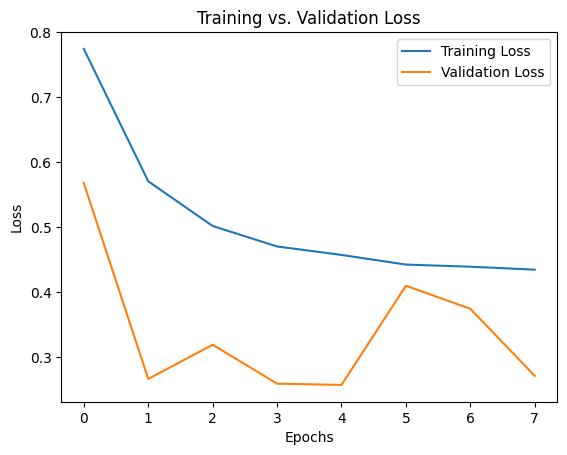

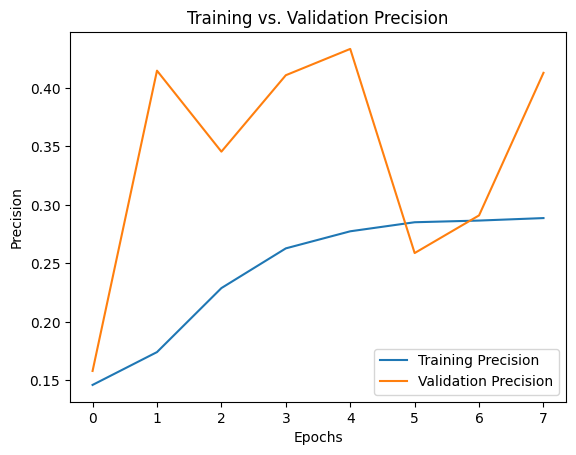

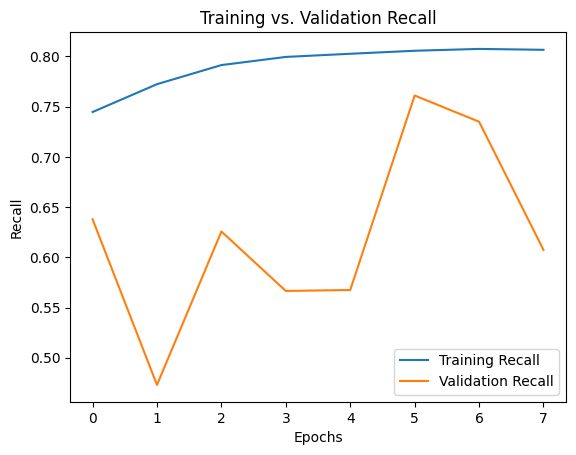

In [17]:
import matplotlib.pyplot as plt

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

# Plot Metrics (e.g., Precision, Recall, AUC)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Training vs. Validation Precision')
plt.show()

plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Training vs. Validation Recall')
plt.show()